## Dataset Information

This project uses the **Chest X-Ray Images (Pneumonia)** dataset from **Guangzhou Women and Children’s Medical Center**.

- **Data Source:** [Mendeley Data Repository](https://data.mendeley.com/datasets/rscbjbr9sj/2)
- **License:** [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **Citation:** [Cell Journal Publication](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

All chest radiographs were screened for quality control before being graded by expert physicians. This dataset is used to train AI models for pneumonia detection based on chest X-ray imaging.


## This work is about fine-tuning the pretrained model on this dataset for classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import copy

### Preparing, Loading and Preprocessing data

In [5]:
for dirname, _, filenames in os.walk('./AI-Medical-Imaging-Recon/data/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

class DummyImageDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        return data

In [3]:
train = get_training_data('./AI-Medical-Imaging-Recon/data/chest_xray/train')
val = get_training_data('./AI-Medical-Imaging-Recon/data/chest_xray/val')
test = get_training_data('./AI-Medical-Imaging-Recon/data/chest_xray/test')

<Axes: xlabel='count'>

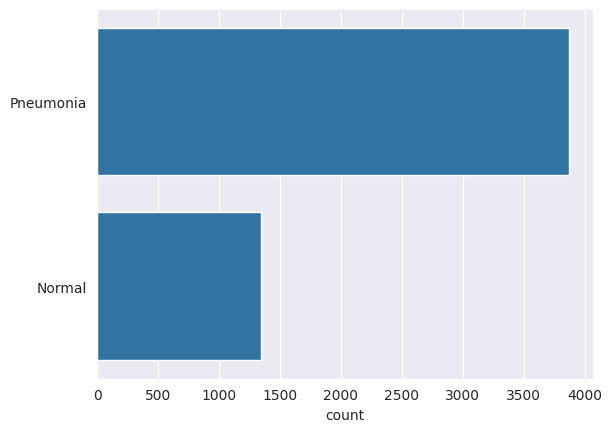

In [16]:
lst_label = []
for i in train:
    if(i[1] == 0):
        lst_label.append("Pneumonia")
    else:
        lst_label.append("Normal")
sns.set_style('darkgrid')
sns.countplot(lst_label) 

Text(0.5, 1.0, 'NORMAL')

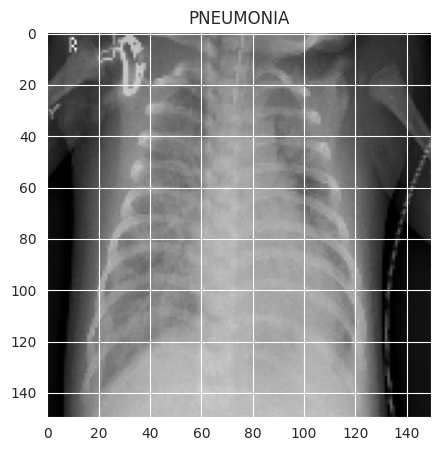

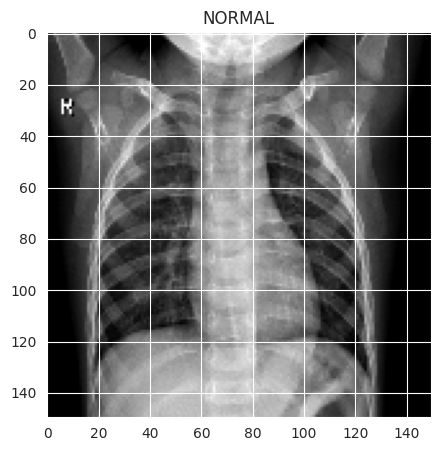

In [17]:
# Visualize checking the data
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [4]:
num_classes = 1
batch_size = 16
num_epochs = 10
learning_rate = 1e-3
model_name = 'resnet18'

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [6]:
data_mean = np.mean(x_train)
data_std = np.std(x_train)

In [7]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std)
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std)
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std)
])

In [8]:
# resize data for deep learning 
x_train = np.array(x_train).reshape(-1, img_size, img_size, 1)

x_val = np.array(x_val).reshape(-1, img_size, img_size, 1)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)

In [9]:
class ImageDataset(Dataset):
    def __init__(self, data, label, transforms=None):
        self.data = data
        self.label = label
        self.transform = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        labels = self.label[idx]

        if self.transform:
            image = self.transform(image)
        return image, labels
    
train_dataset = ImageDataset(x_train, y_train, transforms=train_transforms)
val_dataset = ImageDataset(x_val, y_val, transforms=train_transforms)
test_dataset = ImageDataset(x_test, y_test, transforms=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Building the Unet model architectureBuilding the Unet model architecture

In [10]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
original_conv1 = model.conv1
new_conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=(original_conv1.bias is not None)
)
model.conv1 = new_conv1
for param in model.parameters():
    param.requires_grad = False

for param in model.conv1.parameters():
    param.requires_grad = True

num_lastIn = model.fc.in_features
model.fc = nn.Linear(num_lastIn, num_classes)

### Train the model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [12]:
print('\nParameters to be optimized:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
print('-'*30)


Parameters to be optimized:
conv1.weight
fc.weight
fc.bias
------------------------------


In [17]:
best_val_loss = float('inf')
best_model_wts = None
best_epoch = -1
save_path = 'best_model_chechpoint.pth'
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    total_train = 0
    running_loss = 0.0
    correct_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        probs = torch.sigmoid(output)
        predicted = (probs>0.5).float()

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        #if (i + 1) % 10 == 0:
            #print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / total_train 
    epoch_acc = correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}] complete. Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')

    model.eval()
    current_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            current_val_loss += loss.item() * inputs.size(0)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = current_val_loss / total_val
    epoch_val_acc = correct_val / total_val
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        print(f"New best model found at epoch {best_epoch} with Validation Loss: {best_val_loss:.4f}.")

    scheduler.step()

print('Finish Training')

Epoch [1/10] complete. Training Loss: 0.1271, Training Accuracy: 0.9523
Validation Loss: 4.1763, Validation Accuracy: 0.5000
New best model found at epoch 1 with Validation Loss: 4.1763.
Epoch [2/10] complete. Training Loss: 0.1157, Training Accuracy: 0.9580
Validation Loss: 1.0592, Validation Accuracy: 0.5000
New best model found at epoch 2 with Validation Loss: 1.0592.
Epoch [3/10] complete. Training Loss: 0.1136, Training Accuracy: 0.9576
Validation Loss: 1.1282, Validation Accuracy: 0.5000
Epoch [4/10] complete. Training Loss: 0.1164, Training Accuracy: 0.9561
Validation Loss: 1.1764, Validation Accuracy: 0.5000
Epoch [5/10] complete. Training Loss: 0.1168, Training Accuracy: 0.9548
Validation Loss: 5.1167, Validation Accuracy: 0.5000
Epoch [6/10] complete. Training Loss: 0.1106, Training Accuracy: 0.9611
Validation Loss: 2.0648, Validation Accuracy: 0.5000
Epoch [7/10] complete. Training Loss: 0.1074, Training Accuracy: 0.9599
Validation Loss: 0.7102, Validation Accuracy: 0.5625
N

In [19]:
SAVE_PATH = './AI-Medical-Imaging-Recon/src/checkpoint/'
if best_model_wts:
    model.load_state_dict(best_model_wts)
    print(f'\nLoaded best model weights from epoch {best_epoch} with Validation Loss: {best_val_loss:.4f}')
    torch.save(model.state_dict(), SAVE_PATH+'ResNet18_BinrayClassification_'+save_path)
else:
    print("\nNo best model weights recorded. Saving current model state.")


Loaded best model weights from epoch 9 with Validation Loss: 0.6959


### the validation predication accuracy is pretty low is mainly because our training dataset is imbalance on the 2 labels. the model might quickly learn to predict the majority class all the time. 

### Evaluate the model with test dataset

In [20]:
criterion_name = 'BCEWithLogitsLoss'
model = model.to(device)
model.eval() # Set model to evaluation mode

# --- Testing Loop ---
print("\nStarting testing on the test dataset...")
test_loss = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_true_labels = []

with torch.no_grad(): # No gradients needed for testing
    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        original_labels_for_metrics = labels.clone() # Keep original integer labels for metrics

        if criterion_name == 'BCEWithLogitsLoss':
            labels = labels.float().unsqueeze(1).to(device) # For BCEWithLogitsLoss
        else: # CrossEntropyLoss
            labels = labels.long().to(device) # For CrossEntropyLoss

        outputs = model(inputs) # These are logits
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        if criterion_name == 'BCEWithLogitsLoss':
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
        else: # CrossEntropyLoss
            _, predicted = torch.max(outputs.data, 1)


        total_test += original_labels_for_metrics.size(0)
        if criterion_name == 'BCEWithLogitsLoss':
            correct_test += (predicted == labels).sum().item()
        else: # CrossEntropyLoss
            correct_test += (predicted == original_labels_for_metrics.to(device)).sum().item()


        all_preds.extend(predicted.squeeze().cpu().numpy() if criterion_name == 'BCEWithLogitsLoss' else predicted.cpu().numpy())
        all_true_labels.extend(original_labels_for_metrics.cpu().numpy())




Starting testing on the test dataset...


In [29]:
class_to_idx = {class_name: i for i, class_name in enumerate(['PNEUMONIA', 'NORMAL'])}

if total_test > 0:
    avg_test_loss = test_loss / total_test
    test_acc = correct_test / total_test
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # --- Detailed Metrics ---
    # Ensure all_true_labels and all_preds are flattened if necessary and consistent
    # For binary BCEWithLogits, all_preds might be like [[0.], [1.], [0.]], squeeze if needed
    # all_preds = np.array(all_preds).astype(int) # Ensure integer for classification_report
    # all_true_labels = np.array(all_true_labels).astype(int)

    # Ensure all_preds is a 1D array for classification_report if it's binary from BCEWithLogitsLoss
    if criterion_name == 'BCEWithLogitsLoss':
        all_preds_int = [int(p.item()) for p in torch.tensor(all_preds)] # Convert float predictions (0.0 or 1.0) to int
    else:
        all_preds_int = all_preds

    print("\nClassification Report:")
    # Ensure target_names match your class_to_idx order if you provide them
    # target_names_list = [name for name, idx in sorted(class_to_idx.items(), key=lambda item: item[1])]
    # Make sure class_to_idx is defined based on your training setup.
    # For binary case, target_names might be ['class_0_name', 'class_1_name']
    try:
        # Generate target names based on the class_to_idx used for loading test data
        # This assumes class_to_idx was correctly set up based on training class names
        target_names_list = [""] * len(class_to_idx)
        for name, idx in class_to_idx.items():
            if idx < len(target_names_list):
                 target_names_list[idx] = name
            else:
                print(f"Warning: Index {idx} for class '{name}' is out of bounds for target_names_list of size {len(target_names_list)}")


        if not all(target_names_list): # Check if any name is still an empty string
            print("Warning: Could not determine all target names. Using default integer labels in report.")
            print(classification_report(all_true_labels, all_preds_int))

        else:
            print(classification_report(all_true_labels, all_preds_int, target_names=target_names_list))


        print("\nConfusion Matrix:")
        cm = confusion_matrix(all_true_labels, all_preds_int)
        print(cm)
        # You can use matplotlib or seaborn to plot the confusion matrix for better visualization
        # import seaborn as sns
        # import matplotlib.pyplot as plt
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_list, yticklabels=target_names_list)
        # plt.xlabel('Predicted Label')
        # plt.ylabel('True Label')
        # plt.title('Confusion Matrix')
        # plt.show()

    except Exception as e:
        print(f"Error generating detailed metrics: {e}")
        print("Ensure all_true_labels and all_preds are correctly formatted.")

else:
    print("No test samples were processed. Cannot calculate test metrics.")

print("\nFinished Testing")

Test Loss: 0.6498
Test Accuracy: 0.6154

Classification Report:
              precision    recall  f1-score   support

   PNEUMONIA       0.63      0.92      0.75       390
      NORMAL       0.44      0.10      0.17       234

    accuracy                           0.62       624
   macro avg       0.54      0.51      0.46       624
weighted avg       0.56      0.62      0.53       624


Confusion Matrix:
[[360  30]
 [210  24]]

Finished Testing
